<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Определение-стоимости-автомобилей" data-toc-modified-id="Определение-стоимости-автомобилей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Определение стоимости автомобилей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Первичный анализ</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Работа-с-пропусками" data-toc-modified-id="Работа-с-пропусками-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>Работа с пропусками</a></span></li><li><span><a href="#Анализ-выбросов" data-toc-modified-id="Анализ-выбросов-1.1.2.2"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>Анализ выбросов</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Тестирование моделей</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Первичный анализ

In [41]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('/datasets/autos.csv')
df.info()
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [43]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Прежде чем перейдем к предобработке данных, оставим в датасете только значимые переменные. Предположим, что цена не зависит от:
- Даты скачивания анкеты (DateCrawled)
- Месяца регистрации (важнее год)
- Даты создания анкеты
- Почтового индекса (PostalCode)
- Даты последней активности пользователя (LastSeen)
- Также важно не кол-во фотографий, а их наличие или отсутствие => заменим эту переменную на dummy: 1 - есть фото, 0 - нет.

In [44]:
display(df[df['NumberOfPictures'] > 0])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


В датасете нет объявлений с указанным кол-вом фото => эту переменную также следует пропустить.

In [45]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

**Вывод**   
Убрали лишние переменные, можно приступать к предобработке датасета.

### Предобработка данных

In [46]:
df.info()
print('Дубликатов', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
Дубликатов 45040


**Вывод**
- Датасет содержит 354,369 наблюдений
- Переменные VehicleType, Gearbox, Model, FuelType, NotRepaired содержат пропуски
- Типы переменных указаны верно
- В датасете содержатся 45040 объявлений с идентичными характеристиками. Это могут быть либо одни и те же автомобили (такой информации у нас нет), выложенные в разное время, либо авто с объективной рыночной ценой, обусловленной тех.характеристиками, поэтому эти наблюдения убирать нельзя.

#### Работа с пропусками

**Алгоритм работы с пропусками**   
1. Для восполнения отсутсвующих характеристик образуем поле марки автомобиля BrandName = Brand + Model
2. Удалим наблюдения с нулевой ценой.
3. Подставим VehicleType, Gearbox, FuelType, исходя из марки автомобиля.
4. Пропуски в NotRepaired заменим на "Unknown".

In [47]:
#создадим поле марки авто и уберем объявления с нулевой ценой
df['BrandName'] = df['Brand'] + ' ' + df['Model']
df = df[df['Price'] > 0].reset_index(drop=True)

#для каждого из трех параметров определим наиболее популярную хар-ку, исходя из марки
lst = ['VehicleType', 'Gearbox', 'FuelType']
for element in lst:
    df_pivot_model = df.pivot_table(index='BrandName', columns=element, 
                             values='RegistrationYear', aggfunc='count')
    df_pivot_model = df_pivot_model.fillna(0)
    df_pivot_model['MostCommon'] = ""

    for i in range(df_pivot_model.shape[0]):
        maxi = 0
        for j in range(1, df_pivot_model.shape[1] - 1):
            if df_pivot_model.iat[i, j] > maxi:
                maxi = df_pivot_model.iat[i, j]
                maxi_type = df_pivot_model.columns.values[j]
        df_pivot_model.iat[i, df_pivot_model.shape[1]-1] = maxi_type
    
    display(df_pivot_model.head())

    for i in range(len(df)):
        if df.at[i, element] != df.at[i, element]:
            brand = df.at[i, 'BrandName']
            try: 
                df.at[i, element] = df_pivot_model.at[brand, 'MostCommon']
            except:
                pass

#заменим пропуски в NotRepaired на "Unknown"
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

VehicleType,bus,convertible,coupe,other,sedan,small,suv,wagon,MostCommon
BrandName,,,,,,,,,
alfa_romeo 145,0.0,0.0,2.0,1.0,12.0,19.0,0.0,0.0,small
alfa_romeo 147,0.0,0.0,26.0,7.0,358.0,94.0,0.0,2.0,sedan
alfa_romeo 156,0.0,0.0,3.0,1.0,272.0,2.0,0.0,283.0,wagon
alfa_romeo 159,0.0,0.0,0.0,0.0,55.0,0.0,0.0,144.0,wagon
alfa_romeo other,0.0,1.0,178.0,4.0,180.0,114.0,0.0,6.0,sedan


Gearbox,auto,manual,MostCommon
BrandName,,,
alfa_romeo 145,0.0,39.0,manual
alfa_romeo 147,27.0,516.0,manual
alfa_romeo 156,43.0,537.0,manual
alfa_romeo 159,26.0,182.0,manual
alfa_romeo other,30.0,451.0,manual


FuelType,cng,electric,gasoline,hybrid,lpg,other,petrol,MostCommon
BrandName,,,,,,,,
alfa_romeo 145,0.0,0.0,0.0,0.0,0.0,0.0,41.0,petrol
alfa_romeo 147,0.0,0.0,132.0,0.0,18.0,0.0,385.0,petrol
alfa_romeo 156,0.0,0.0,184.0,0.0,15.0,0.0,352.0,petrol
alfa_romeo 159,0.0,0.0,139.0,0.0,0.0,0.0,58.0,gasoline
alfa_romeo other,0.0,0.0,116.0,0.0,1.0,0.0,362.0,petrol


Также можно предположить, что цена автомобиля обусловлена не конкретной моделью, а брендом и тех. характеристиками => поля Model и BrandName можно удалить.

In [48]:
df = df.drop(['Model', 'BrandName'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343597 entries, 0 to 343596
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343597 non-null  int64 
 1   VehicleType       338013 non-null  object
 2   RegistrationYear  343597 non-null  int64 
 3   Gearbox           340512 non-null  object
 4   Power             343597 non-null  int64 
 5   Kilometer         343597 non-null  int64 
 6   FuelType          337689 non-null  object
 7   Brand             343597 non-null  object
 8   NotRepaired       343597 non-null  object
dtypes: int64(4), object(5)
memory usage: 23.6+ MB


Наибольшее число пропусков лежит в поле FuelType (~6K или 1.7%) всех наблюдений => от этих данных можно смело отказаться.

In [49]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334953 entries, 0 to 334952
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334953 non-null  int64 
 1   VehicleType       334953 non-null  object
 2   RegistrationYear  334953 non-null  int64 
 3   Gearbox           334953 non-null  object
 4   Power             334953 non-null  int64 
 5   Kilometer         334953 non-null  int64 
 6   FuelType          334953 non-null  object
 7   Brand             334953 non-null  object
 8   NotRepaired       334953 non-null  object
dtypes: int64(4), object(5)
memory usage: 23.0+ MB


**Вывод**   
Путем подбора параметров через марку автомобиля и замены пропусков в поле NotRepaired удалось сохранить 95% выборки.

#### Анализ выбросов

Итак, в датасете осталось 9 параметров: 4 числовых и 5 категориальных. Проанализируем распределения каждого из них и избавимся от выбросов (если они присутствуют).

In [50]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
df[numeric].describe()

,Price,RegistrationYear,Power,Kilometer
count,334953.000000,334953.000000,334953.000000,334953.000000
mean,4606.021705,2003.808630,112.062167,128500.580678
std,4529.112872,65.890261,188.449332,37156.672482
min,1.000000,1000.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,71.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6599.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**Вывод**   
Есть ряд подозрительных наблюдений:
1. авто стоимостью меньше 100 euro
2. авто с регистрацией ранее 1950 и позже 2020
3. авто с мощностью меньше 30 и более 300
4. также интересно, что большинство авто представлены с очень большим пробегом (120,000 +)   
   
Избавимся от подозрительных значений и построим распределения параметров.

In [51]:
print('Подозрительная цена:', df.query('Price <= 100')['Price'].count())
print('Подозрительный год:', df.query('RegistrationYear <= 1950 | RegistrationYear > 2020')['Price'].count())
print('Подозрительная мощность:', df.query('Power < 30 | Power > 300')['Price'].count())

Подозрительная цена: 3060
Подозрительный год: 192
Подозрительная мощность: 36719


Поскольку данные характеристики являются ключевыми для ценообразования, придется эти выбросы (скорее всего, незаполненные данные) удалить.

In [52]:
df = df.query('Price > 100 & RegistrationYear > 1950 & RegistrationYear <= 2020 & Power >= 30 & Power <= 300')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296465 entries, 1 to 334952
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296465 non-null  int64 
 1   VehicleType       296465 non-null  object
 2   RegistrationYear  296465 non-null  int64 
 3   Gearbox           296465 non-null  object
 4   Power             296465 non-null  int64 
 5   Kilometer         296465 non-null  int64 
 6   FuelType          296465 non-null  object
 7   Brand             296465 non-null  object
 8   NotRepaired       296465 non-null  object
dtypes: int64(4), object(5)
memory usage: 22.6+ MB


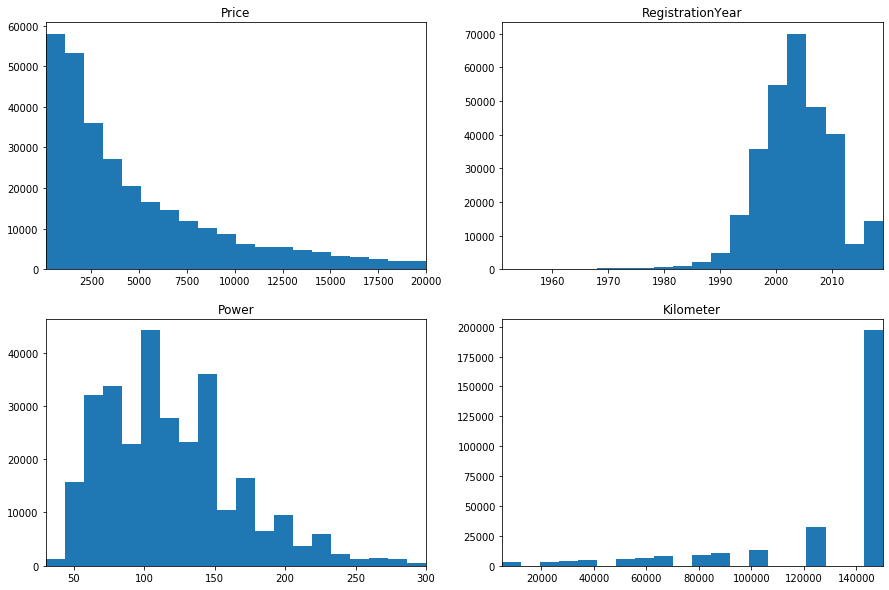

In [53]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(numeric)):
    i = i+1
    plt.subplot(2, 2, i)
    plt.hist(df[numeric[i-1]], bins = 20)
    plt.title(numeric[i-1])
    plt.xlim(min(df[numeric[i-1]]), max(df[numeric[i-1]]))

Далее взглянем на категориальные переменные.

In [54]:
categorical = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']
for element in categorical:
    pivot = df.pivot_table(index=element, values='Price', aggfunc='count').sort_values(by='Price', ascending=False)
    display(pivot)

,Price
VehicleType,
sedan,88875
small,73958
wagon,61717
bus,26028
convertible,18445
coupe,14141
suv,10772
other,2529


,Price
Gearbox,
manual,239570
auto,56895


,Price
FuelType,
petrol,199471
gasoline,91738
lpg,4471
cng,491
hybrid,202
other,55
electric,37


,Price
Brand,
volkswagen,65307
opel,32979
bmw,31661
mercedes_benz,26753
audi,25354
ford,20870
renault,14232
peugeot,9355
fiat,7641


,Price
NotRepaired,
no,224602
unknown,43695
yes,28168


**Вывод**   
В категориальных переменных нет каких-либо значимых смещений => можно приступать к дальнейшему анализу.

## Обучение моделей

Распределим переменные на x_cat, x_num:

In [55]:
df = df.reset_index(drop=True)
x_cat = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']
x_num = ['RegistrationYear', 'Power', 'Kilometer']

In [56]:
#преобразуем категориальные переменные в dummy
df = pd.get_dummies(df, columns=x_cat)

In [57]:
#разделим выборки на обучающую и валидационную
target = df['Price']
features = df.drop('Price', axis=1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, 
                                                                              test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, 
                                                                              test_size=0.5, random_state=12345)

В качестве опций рассмотрим следующие:
1. Линейная регрессия
2. LightGBM с подбором гиперпараметров 

Модели будем оценивать с помощью двух метрик:
1. RMSE
2. Cкорость выполнения %%time

## Анализ моделей

### Линейная регрессия

In [58]:
%%time
#линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
mse = mean_squared_error(target_valid, prediction)
rmse = mse ** 0.5
print(rmse)

2761.517673716305
CPU times: user 8.04 s, sys: 1.42 s, total: 9.47 s
Wall time: 1.4 s


### LightGBM

In [59]:
%%time
#базовый LightGBM с разными типами бустинга
types = ['gbdt', 'dart', 'goss']
for t in types:
    model = LGBMRegressor(boosting_type = t)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    mse = mean_squared_error(target_valid, prediction)
    rmse = mse ** 0.5
    print(t, rmse)

gbdt 1699.3572138985612
dart 1949.2740591176084
goss 1697.1708103278945
CPU times: user 23.8 s, sys: 1.46 s, total: 25.3 s
Wall time: 3.23 s


**Вывод**   
Наилучший показатель за типом goss => далее работаем с ним.

In [60]:
%%time
#базовый LightGBM типа 'goss' с подбором параметров
estimators = [1, 10, 100, 1000]
m_depth = 11

rmse_min = 10000
n_best = 0
d_best = 0
for n in estimators:
    for d in range(1, m_depth):
        model = LGBMRegressor(boosting_type = 'goss', n_estimators = n, max_depth = d, num_leaves = 2**d)
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        mse = mean_squared_error(target_valid, prediction)
        rmse = mse ** 0.5
        print(f'деревьев {n}, глубина {d}: {rmse}')
        if rmse < rmse_min:
            rmse_min = rmse
            n_best = n
            d_best = d
            
print()
print(f'Лучшие параметры: кол-во деревьев - {n_best}, глубина - {d_best}, rmse - {rmse_min}')

деревьев 1, глубина 1: 4377.845413416695
деревьев 1, глубина 2: 4310.790018743958
деревьев 1, глубина 3: 4272.510352319203
деревьев 1, глубина 4: 4234.458902192244
деревьев 1, глубина 5: 4210.350535474585
деревьев 1, глубина 6: 4194.984127938589
деревьев 1, глубина 7: 4183.1892646286515
деревьев 1, глубина 8: 4174.653483488857
деревьев 1, глубина 9: 4168.157128129134
деревьев 1, глубина 10: 4162.918770688702
деревьев 10, глубина 1: 3647.668208535359
деревьев 10, глубина 2: 3190.0376651400334
деревьев 10, глубина 3: 2948.7227335251987
деревьев 10, глубина 4: 2748.5113815651557
деревьев 10, глубина 5: 2633.287874678287
деревьев 10, глубина 6: 2551.6872242044756
деревьев 10, глубина 7: 2486.7450366579433
деревьев 10, глубина 8: 2432.7118306551333
деревьев 10, глубина 9: 2386.972675907121
деревьев 10, глубина 10: 2349.893249437908
деревьев 100, глубина 1: 2459.5145343251893
деревьев 100, глубина 2: 2053.1694370539867
деревьев 100, глубина 3: 1904.7968629991453
деревьев 100, глубина 4: 1810

  Получили ожидаемый результат: чем больше количество деревьев и их глубина, тем точнее результат, однако скорость работы заметно падает. Сравним скорости у моделей с параметрами 100-10 и 1000-9, rmse по которым практически сопоставимы.

### Тестирование моделей

**Линейная регрессия**

In [61]:
%%time
#линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 7.68 s, sys: 1.62 s, total: 9.3 s
Wall time: 1.38 s


LinearRegression()

In [62]:
%%time
prediction = model.predict(features_test)

CPU times: user 25.3 ms, sys: 11.6 ms, total: 36.9 ms
Wall time: 6.47 ms


In [63]:
mse = mean_squared_error(target_test, prediction)
rmse = mse ** 0.5
print(rmse)

2756.4193993153035


**LGBMRegressor 100-10**

In [64]:
%%time
model = LGBMRegressor(boosting_type = 'goss', n_estimators = 100, max_depth = 10, num_leaves = 2**10)
model.fit(features_train, target_train)

CPU times: user 10.3 s, sys: 807 ms, total: 11.1 s
Wall time: 1.46 s


LGBMRegressor(boosting_type='goss', max_depth=10, num_leaves=1024)

In [65]:
%%time
prediction = model.predict(features_test)

CPU times: user 902 ms, sys: 24 ms, total: 926 ms
Wall time: 127 ms


In [66]:
mse = mean_squared_error(target_test, prediction)
rmse = mse ** 0.5
print(rmse)

1596.446113301403


**LGBMRegressor 1000-9**

In [67]:
%%time
model = LGBMRegressor(boosting_type = 'goss', n_estimators = 1000, max_depth = 9, num_leaves = 2**9)
model.fit(features_train, target_train)

CPU times: user 1min 6s, sys: 4 s, total: 1min 10s
Wall time: 9.03 s


LGBMRegressor(boosting_type='goss', max_depth=9, n_estimators=1000,
              num_leaves=512)

In [68]:
%%time
prediction = model.predict(features_test)

CPU times: user 7.86 s, sys: 39.8 ms, total: 7.9 s
Wall time: 1.02 s


In [69]:
mse = mean_squared_error(target_test, prediction)
rmse = mse ** 0.5
print(rmse)

1552.52618507501


**Вывод**   
Скорость работы возрастает в 6 раз при снижении RMSE на 3% =>    
модель LGBMRegressor типа 'goss' со 100 деревьями и глубиной 9 - наиболее оптимальна и обеспечивает RMSE на уровне 1596, что также на порядок лучше показателей обычной линейной регрессии.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей